<a href="https://colab.research.google.com/github/ever-oli/MLby22/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 9.91M/9.91M [00:00<00:00, 61.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.82MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.7MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.53MB/s]


Starting training on MNIST...
Epoch 0 | D Loss: 0.5380 | G Loss: 0.8059


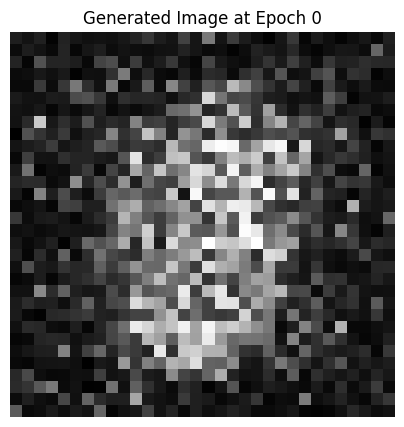

Epoch 10 | D Loss: 0.4736 | G Loss: 0.7641


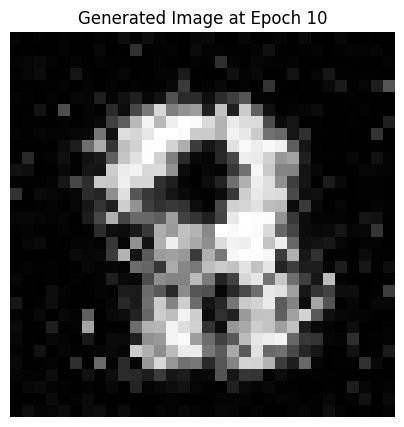

Epoch 20 | D Loss: 0.7461 | G Loss: 0.3995


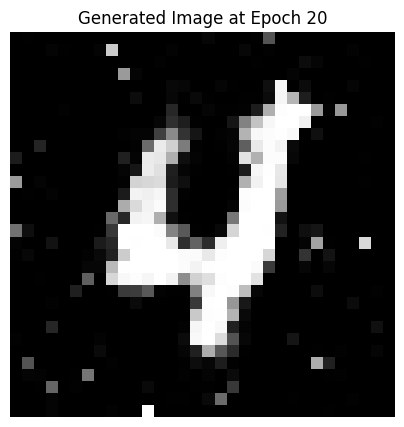

Epoch 30 | D Loss: 0.5531 | G Loss: 1.1026


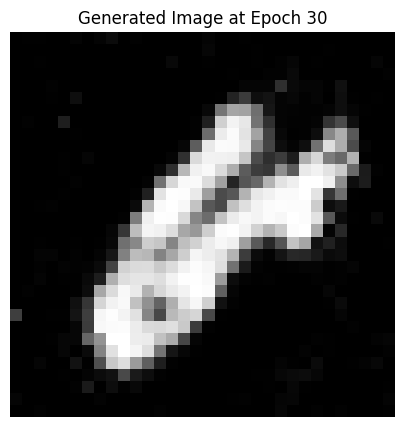

Epoch 40 | D Loss: 0.5990 | G Loss: 1.5287


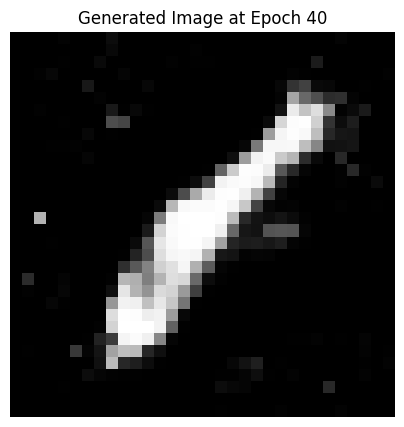

Epoch 49 | D Loss: 0.5244 | G Loss: 0.7481


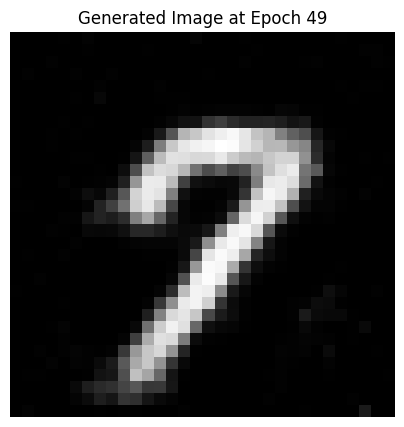

Training complete.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# 1. Configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
# Options: 'MNIST' (1x28x28) or 'CIFAR10' (3x32x32)
DATASET_NAME = 'MNIST'
batch_size = 128
latent_dim = 100
lr = 0.0002
epochs = 50

# 2. Data Preparation
if DATASET_NAME == 'MNIST':
    transform = transforms.Compose([
        transforms.Resize(32), # Resize to 32 to simplify architecture sharing
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
    dataset = datasets.MNIST(root=".", train=True, download=True, transform=transform)
    channels = 1
else:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    dataset = datasets.CIFAR10(root=".", train=True, download=True, transform=transform)
    channels = 3

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 3. Model Architectures
class Generator(nn.Module):
    def __init__(self, channels):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, channels * 32 * 32),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), channels, 32, 32)
        return img

class Discriminator(nn.Module):
    def __init__(self, channels):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channels * 32 * 32, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        validity = self.model(img)
        return validity

# Initialize models
gen = Generator(channels).to(device)
disc = Discriminator(channels).to(device)

adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))

# 4. Training Loop
print(f"Starting training on {DATASET_NAME}...")

for epoch in range(epochs):
    for i, (imgs, _) in enumerate(dataloader):

        real = imgs.to(device)
        valid = torch.ones(imgs.size(0), 1).to(device)
        fake = torch.zeros(imgs.size(0), 1).to(device)

        # --- Train Generator ---
        optimizer_G.zero_grad()
        z = torch.randn(imgs.size(0), latent_dim).to(device)
        gen_imgs = gen(z)
        g_loss = adversarial_loss(disc(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # --- Train Discriminator ---
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(disc(real), valid)
        fake_loss = adversarial_loss(disc(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    # Visualization every 10 epochs
    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")
        plt.figure(figsize=(5,5))
        grid_img = gen_imgs[0].cpu().detach().numpy().transpose(1, 2, 0)
        if channels == 1:
            plt.imshow(grid_img.squeeze(), cmap='gray')
        else:
            plt.imshow((grid_img * 0.5 + 0.5)) # Denormalize
        plt.title(f"Generated Image at Epoch {epoch}")
        plt.axis('off')
        plt.show()

print("Training complete.")

Commencing DCGAN training on MNIST...
[0/25] Loss_D: 0.2478 Loss_G: 2.7745


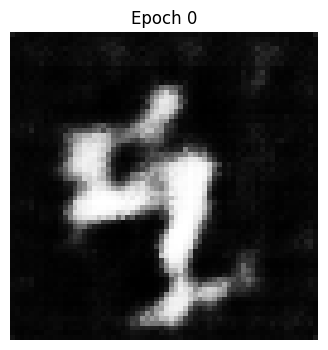

KeyboardInterrupt: 

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# 1. Configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
DATASET_NAME = 'MNIST' # Works well for CIFAR10 too
batch_size = 128
latent_dim = 100
lr = 0.0002
epochs = 25 # DCGAN converges faster than linear GANs

# 2. Data Preparation
if DATASET_NAME == 'MNIST':
    transform = transforms.Compose([
        transforms.Resize(64), # Upscale to 64x64 for standard DCGAN architecture
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
    dataset = datasets.MNIST(root=".", train=True, download=True, transform=transform)
    channels = 1
else:
    transform = transforms.Compose([
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    dataset = datasets.CIFAR10(root=".", train=True, download=True, transform=transform)
    channels = 3

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 3. DCGAN Model Architectures
def weights_init(m):
    """ Custom weight initialization recommended by the DCGAN paper """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self, channels):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input is latent_dim, going into a convolution
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # State size: (512) x 4 x 4
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # State size: (256) x 8 x 8
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # State size: (128) x 16 x 16
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # State size: (64) x 32 x 32
            nn.ConvTranspose2d(64, channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # Final state size: (channels) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self, channels):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input is (channels) x 64 x 64
            nn.Conv2d(channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: (64) x 32 x 32
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: (128) x 16 x 16
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: (256) x 8 x 8
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: (512) x 4 x 4
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1)

# Initialize models
netG = Generator(channels).to(device)
netG.apply(weights_init)
netD = Discriminator(channels).to(device)
netD.apply(weights_init)

criterion = nn.BCELoss()
# Fixed noise to visualize progress consistently
fixed_noise = torch.randn(1, latent_dim, 1, 1, device=device)
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

# 4. Training Loop
print(f"Commencing DCGAN training on {DATASET_NAME}...")

for epoch in range(epochs):
    for i, data in enumerate(dataloader, 0):
        # Update Discriminator: maximize log(D(x)) + log(1 - D(G(z)))
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), 1.0, device=device)

        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()

        noise = torch.randn(b_size, latent_dim, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(0.0)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        optimizerD.step()

        # Update Generator: maximize log(D(G(z)))
        netG.zero_grad()
        label.fill_(1.0)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()

    # Visualization
    if epoch % 5 == 0 or epoch == epochs - 1:
        print(f'[{epoch}/{epochs}] Loss_D: {errD_real.item()+errD_fake.item():.4f} Loss_G: {errG.item():.4f}')
        with torch.no_grad():
            fake_display = netG(fixed_noise).detach().cpu()
        plt.figure(figsize=(4,4))
        img_plot = np.transpose(fake_display[0], (1, 2, 0))
        if channels == 1:
            plt.imshow(img_plot.squeeze(), cmap='gray')
        else:
            plt.imshow((img_plot * 0.5 + 0.5))
        plt.axis('off')
        plt.title(f"Epoch {epoch}")
        plt.show()

print("DCGAN training complete.")

In [ ]:
def interpolate_latent_space(model, n_steps=10):
    model.eval()

    # 1. Pick two random points in the latent space
    z1 = torch.randn(1, latent_dim, 1, 1, device=device)
    z2 = torch.randn(1, latent_dim, 1, 1, device=device)

    # 2. Create interpolation steps (alphas from 0 to 1)
    alphas = np.linspace(0, 1, n_steps)

    plt.figure(figsize=(15, 3))
    print("Morphing through latent space...")

    with torch.no_grad():
        for i, alpha in enumerate(alphas):
            # Linearly interpolate between z1 and z2
            z_interp = (1 - alpha) * z1 + alpha * z2

            # Generate image from the interpolated vector
            generated_img = model(z_interp).cpu().squeeze()

            # Plotting
            plt.subplot(1, n_steps, i + 1)
            img_plot = generated_img.numpy()

            if channels == 1:
                plt.imshow(img_plot, cmap='gray')
            else:
                # Denormalize CIFAR images for display
                plt.imshow(np.transpose(img_plot * 0.5 + 0.5, (1, 2, 0)))

            plt.axis('off')
            plt.title(f"α={alpha:.1f}")

    plt.suptitle(f"Latent Space Interpolation ({DATASET_NAME})")
    plt.show()

# Run the interpolation
interpolate_latent_space(netG, n_steps=10)